# AutoEncoder

We are going to build a Denoising Autoencoder just using numpy and look at the math behind it.

## Imports 

In [1]:
import os
import csv
import numpy as np
import matplotlib.pyplot as plt
import random

%matplotlib inline
np.random.seed(0)

## Loading Data

For this example we will use the mnist dataset. So let us load the data and define a function to view it and shuffle it too.

In [2]:
def load_data():
    data_dir = 'data/'
 
    data_train = np.genfromtxt(os.path.join(data_dir,'digitstrain.txt'),delimiter=',')
    data_valid = np.genfromtxt(os.path.join(data_dir,'digitsvalid.txt'),delimiter=',')
    data_test = np.genfromtxt(os.path.join(data_dir,'digitstest.txt'),delimiter=',')

    #training data
    X_train = data_train[:,:-1]
    y_train = data_train[:,-1]
    #validation data
    X_valid = data_valid[:,:-1]
    y_valid = data_valid[:,-1]
    #testing data
    X_test = data_test[:,:-1]
    y_test = data_test[:,-1]

    return{'train':{'X':X_train,'y':y_train},'valid':{'X':X_valid,'y':y_valid},'test':{'X':X_test,'y':y_test}}

def visualize_digit(X):
    image = np.reshape(X,(28,28))
    plt.imshow(image)
    plt.show()

# shuffles a list
def shuffle(X):
    index_shuf = np.arange(X.shape[0])
    random.shuffle(index_shuf)

    return index_shuf

Now we can load the data and take a look at few of the numbers

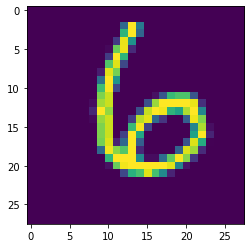

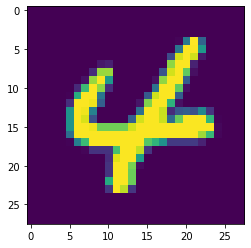

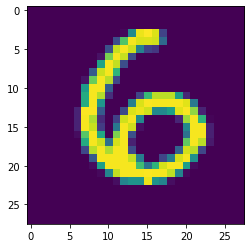

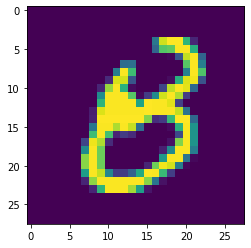

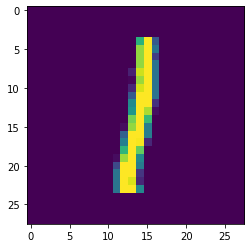

In [3]:
data = load_data()
X_train = data['train']['X']
y_train = data['train']['y']
X_valid = data['valid']['X']
y_valid = data['valid']['y']
X_test = data['test']['X']
y_test = data['test']['y']

for i in range(5):
    visualize_digit(X_train[random.randrange(len(X_train))])

Great, now we can focus on the autoencoder.

# Introduction to Autoencoders

Autoencoders are a specific type of feedforward neural networks where the input is the same as the output. They compress the input into a lower-dimensional code and then reconstruct the output from this representation. The code is a compact “summary” or “compression” of the input, also called the latent-space representation.

An autoencoder consists of 3 components: encoder, code and decoder. The encoder compresses the input and produces the code, the decoder then reconstructs the input only using this code.

![alt_image](https://miro.medium.com/max/1400/1*MMRDQ4g3QvQNc7iJsKM9pg@2x.png)

The math behind the networks is fairly easy to understand, so I will go through it briefly. Essentially, we split the network into two segments, the encoder, and the decoder.

![alt_image](https://miro.medium.com/max/1232/1*gznHzPgOqmR4JDC5KN0tKQ.png)

The encoder function, denoted by ϕ, maps the original data X, to a latent space F, which is present at the bottleneck. The decoder function, denoted by ψ, maps the latent space F at the bottleneck to the output. The output, in this case, is the same as the input function. Thus, we are basically trying to recreate the original image after some generalized non-linear compression.
The encoding network can be represented by the standard neural network function passed through an activation function, where z is the latent dimension.

![alt_image](https://miro.medium.com/max/620/1*_0KqHhVrfC-jDiwk8zVaMg.png)

Similarly, the decoding network can be represented in the same fashion, but with different weight, bias, and potentially activation functions being used.

![alt_image](https://miro.medium.com/max/724/1*5MmrBGJ1pg8fxGLRPGZz5Q.png)

The loss function can then be written in terms of these network functions, and it is this loss function that we will use to train the neural network through the standard backpropagation procedure.

![alt_image](https://miro.medium.com/max/1400/1*9vKKvaCnyg9bjJDt3TPFuw.png)

Since the input and output are the same images, this is not really supervised or unsupervised learning, so we typically call this self-supervised learning. The aim of the autoencoder is to select our encoder and decoder functions in such a way that we require the minimal information to encode the image such that it be can regenerated on the other side.
If we use too few nodes in the bottleneck layer, our capacity to recreate the image will be limited and we will regenerate images that are blurry or unrecognizable from the original. If we use too many nodes, then there is little point in using compression at all.

## Activation Functions

Let us define a few activation functions and their derivatives to be used later.

In [4]:
class linearActivationFunction(object):
    @staticmethod
    def func(x):
      return x

    @staticmethod  
    def derivative(x):
        """Derivative of the linear function."""
        return np.zeros(x.shape)

class reluActivationFunction(object):
    @staticmethod
    def func(x):
        out=x
        out[x<0]=0
        return out 

    @staticmethod  
    def derivative(x):
        """Derivative of the relu function."""
        return np.asarray((x>0),np.float) 

class tanhActivationFunction(object):
    @staticmethod
    def func(x):
      return np.tanh(x)

    @staticmethod  
    def derivative(x):
        """Derivative of the tanh function."""
        return 1-np.power(np.tanh(x), 2) 


class sigmoidActivationFunction(object):
    @staticmethod
    def func(x):
      return 1./ (1 + np.exp(-x))

    @staticmethod  
    def derivative(x):
        """Derivative of the sigmoid function."""
        sigmoid = 1./ (1 + np.exp(-x))
        return sigmoid*(1-sigmoid)

def softmax(x):
    exp_scores = np.exp(x)
    return 1.*exp_scores / np.sum(exp_scores, axis=1, keepdims=True)

## Defining the Autoencoder

Let us now define the autoencoder class.

In [5]:
class autoencoder:
    def __init__(self, layers, hyper_params, activation_function, denoising=False ,logging=False,load_model=False, temp_save=True, output_freq=5):
        self.denoising = denoising
        self.nn_input_dim = layers[0]  # input layer dimensionality
        self.nn_output_dim = layers[-1]  # output layer dimensionality
        self.load=load_model
        self.temp_save = temp_save # save weights in temporary folder
        self.layers = layers

        self.alpha=hyper_params['learning_rate']  # learning rate for gradient descent
        self.reg_lambda=hyper_params['regularizer']  # weight decay
        self.gamma = hyper_params['momentum_weight'] # momentum weight 
        
        self.activation_function=activation_function

        self.logging=logging
        self.output_freq = output_freq

        #Keeping track of the momentum of the weights the gradients of the weights for momentum calculation
        self.gradients={}
        if not load_model:
            self.weights_initialization()
        else:
            self.model = pickle.load(open(self.filename, 'rb'))
        
        
    def weights_initialization(self):
        self.model = {}
        for i, (_in, _out) in enumerate(zip(self.layers[:-1], self.layers[1:])):
            W = np.random.normal(0, 0.1, (_in, _out))
            b = np.zeros((1, _out))
            self.model.update({'W'+str(i+1):W,'b'+str(i+1):b})
            self.gradients.update({'dW'+str(i+1):0*W})


    # function for visualizing the weights of the hidden layer
    def visualize_weights(self, title):
        weights = self.model['W1']
        reshaped_weights = np.reshape(weights,(28,28,self.layers[1]))
        plt.figure(1)
        for i in range(self.layers[1]):
            ax = plt.subplot(np.sqrt(self.layers[1]),np.sqrt(self.layers[1]),i+1)	
            ax.imshow(reshaped_weights[:,:,i],cmap = 'gray')
            plt.axis('off')
        plt.pause(1)

    def calculate_entropy_loss(self, X):
        num_examples = len(X)  # train size
        decoded,_,_ = self.forward(X)
        
        logprobs = -np.multiply(np.log(decoded),X) - np.multiply(np.log(1.0-decoded),1.0-X)		
        data_loss = np.sum(logprobs)
        return 1.*data_loss / num_examples 

    def decode(self, x):
        decoded,_,_ = self.forward(x)
        return decoded

    def forward(self, x):
        L=len(self.layers)-2 # number of hidden layers 
        act_h=[x]
        act_a=[x]
        # Forward propagation
        for j in range(L):
            W = self.model['W'+str(j+1)]
            b = self.model['b'+str(j+1)]

            a = act_h[-1].dot(W) + b
            h=self.activation_function.func(a)

            act_a.append(a)
            act_h.append(h)

        W = self.model['W'+str(len(self.layers)-1)]
        b = self.model['b'+str(len(self.layers)-1)]
        a = act_h[-1].dot(W) + b	
        decoded = self.activation_function.func(a)
        return decoded, act_h, act_a

    def backprob(self, mini_batch, noisy_mini_batch):
        # Forward propagation
        if noisy_mini_batch is None:
            X= mini_batch
        else: 
            X= noisy_mini_batch

        L=len(self.layers)-2 # number of hidden layers 
        size_miniBatch = len(X)
        decoded, act_h, act_a = self.forward(X)
        output_gradient = decoded - mini_batch

        for j in range(L+1, 0, -1):
            W = self.model['W'+str(j)]
            b = self.model['b'+str(j)]
            dW_prev = self.gradients['dW'+str(j)]# for momentum calculation

            dW = (act_h[j-1].T).dot(output_gradient)
            db = np.sum(output_gradient, axis=0, keepdims=True)
            output_gradient = output_gradient.dot(W.T) * self.activation_function.derivative(act_a[j-1]) #sigmoid_dot(act[j-1])#(1 - np.power(act[j-1], 2))
            dW += self.reg_lambda*W + self.gamma*dW_prev

            dW = dW/size_miniBatch
            db = db/size_miniBatch

            W -= self.alpha * dW
            b -= self.alpha * db
            
            self.model.update({'W'+str(j):W,'b'+str(j):b})
            self.gradients.update({'dW'+str(j):dW})		


    def train_model(self, data, mini_batch_size=1 ,num_epochs=200, print_loss=False,visualize_wegiths_while_training=False):
        # Initialize the parameters to random values. We need to learn these.
        X = data['train']['X']
        X_valid = data['valid']['X']

        train_loss_array=[]
        valid_loss_array=[]
        
        for i in range(0, num_epochs):

            N=len(X) # size of training set
            shuffled_indices = shuffle(X)
            X = X[shuffled_indices,:]
            
            X_noisy = None
            if self.denoising:
                X_noisy=self.add_noise(X)
                noisy_mini_batches = [X_noisy[k:k+mini_batch_size,:] for k in np.arange(0, N, mini_batch_size)]
            mini_batches = [X[k:k+mini_batch_size,:] for k in np.arange(0, N, mini_batch_size)]
            
            for j in range(N//mini_batch_size):
                if self.denoising:
                    self.backprob(mini_batches[j], noisy_mini_batches[j]) # does backpropagation on a batch and updates weights of the model
                else:
                    self.backprob(mini_batches[j], None)

            if self.logging:
                train_loss = self.calculate_entropy_loss(X)
                valid_loss = self.calculate_entropy_loss(X_valid)
                train_loss_array.append(train_loss)
                valid_loss_array.append(valid_loss)
                self.logs={'losses':{'train':train_loss_array,'valid':valid_loss_array}}

            if print_loss and (i+1) % self.output_freq == 0:
                if visualize_wegiths_while_training:
                    self.visualize_weights('epoch_'+str(i+1))
    
                if not self.logging:
                    train_loss = self.calculate_entropy_loss(X)
                
                print('[Epoch: %i ...training Loss: %f]' % (i+1, train_loss))

        return self.model

    def visualize_decoded(self,x_test):
        n=10 # number of digits to test on
        ind = np.random.choice(x_test.shape[0], n)

        plt.figure(figsize=(20, 4))
        for i in range(n):

            # display original
            ax = plt.subplot(2, n, i + 1)
            plt.imshow(x_test[ind[i]].reshape(28, 28))
            plt.gray()
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)

            # display reconstruction
            ax = plt.subplot(2, n, i + 1 + n)
            decoded = self.decode(x_test[ind[i]])
            plt.imshow(decoded.reshape(28, 28))
            plt.gray()
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)
        plt.show()

    def add_noise(self, X, display=False):
        ind0 = np.random.choice(X.shape[0], int(np.floor(0.1*X.size)))
        ind1 = np.random.choice(X.shape[1], int(np.floor(0.1*X.size)))
        X_noisy = X.copy()
        X_noisy[ind0,ind1] = 0
        X_noisy = X_noisy + np.random.normal(0, 0.3,X_noisy.shape)
        
        if display:
            n=10 # number of digits to test on
            ind = np.random.choice(X.shape[0], n)

            plt.figure(figsize=(20, 4))
            for i in range(n):
                # display original
                ax = plt.subplot(2, n, i + 1)
                plt.imshow(X[ind[i]].reshape(28, 28))
                plt.gray()
                ax.get_xaxis().set_visible(False)
                ax.get_yaxis().set_visible(False)
                
                # display reconstruction
                ax = plt.subplot(2, n, i + 1 + n)
                plt.imshow(X_noisy[ind[i]].reshape(28, 28))
                plt.gray()
                ax.get_xaxis().set_visible(False)
                ax.get_yaxis().set_visible(False)
            plt.show()
        return X_noisy


## Hyperparameters

Now as we have the autoencoder let us define the hyperparameter for this network

In [6]:
parameters={'learning_rate': 0.2, 'regularizer': 0.001, 'momentum_weight': 0.9, 'mini_batch_size':100 }

## Plot Losses

Lets also define a function to plot the loss of the network during training

In [7]:
def plot_logs(logs):
    if 'accuracies' in logs.keys():	
        train_acc_array=logs['accuracies']['train']#training accuracy
        valid_acc_array=logs['accuracies']['valid']#validation accuracy
    if 'losses' in logs.keys():		
        train_loss_array=logs['losses']['train'] # average entropy loss
        valid_loss_array=logs['losses']['valid'] # average entropy loss
    
    num_epochs = len(logs[list(logs.keys())[0]]['train'])
    
    x = range(1,num_epochs+1)
    n = len(logs.keys())
    f, axarr = plt.subplots(n, sharex=True)
    i=0
    if n==1:
        axarr=[axarr]
    
    if 'accuracies' in logs.keys():	
        axarr[i].plot(x, train_acc_array,color='r',label='train')
        axarr[i].plot(x, valid_acc_array,color='b',label='valid')
        axarr[i].set_title('Accuracies vs. Number of Epochs')
        i=i+1

    if 'losses' in logs.keys():
        axarr[i].plot(x, train_loss_array,color='r',label='train')
        axarr[i].plot(x, valid_loss_array,color='b',label='valid')
        axarr[i].set_title('Average Entropy Losses vs. Number of Epochs')
        i=i+1

    plt.legend()
    plt.show()


## Training 

Now we can initilize the network and start training.

In [8]:
epochs = 25

act_function=sigmoidActivationFunction #sigmoidActivationFunction or tanhActivationFunction or reluActivationFunction  
layers = [28*28, 100, 28*28] # specify the dimension of each layer [inputLayer, hidden1, hidden2 ...hiddenM, OutputLayer]

#Initialize the network (number of layers, number of nodes in hidden layers, load weights ... )
my_autoencoder = autoencoder(layers=layers, denoising=True, logging=True, hyper_params=parameters,activation_function=act_function, load_model=False, temp_save=True, output_freq=1)

print("Training..........")
model = my_autoencoder.train_model(data, mini_batch_size=parameters['mini_batch_size'], num_epochs=epochs, print_loss=True, visualize_wegiths_while_training=False)

Training..........
[Epoch: 1 ...training Loss: 182.434265]
[Epoch: 2 ...training Loss: 149.860052]
[Epoch: 3 ...training Loss: 138.280657]
[Epoch: 4 ...training Loss: 130.215130]
[Epoch: 5 ...training Loss: 123.453062]
[Epoch: 6 ...training Loss: 113.420176]
[Epoch: 7 ...training Loss: 109.427525]
[Epoch: 8 ...training Loss: 106.688543]
[Epoch: 9 ...training Loss: 107.600284]
[Epoch: 10 ...training Loss: 102.040141]
[Epoch: 11 ...training Loss: 102.458854]
[Epoch: 12 ...training Loss: 100.575258]
[Epoch: 13 ...training Loss: 94.201639]
[Epoch: 14 ...training Loss: 98.536824]
[Epoch: 15 ...training Loss: 101.577532]
[Epoch: 16 ...training Loss: 92.197421]
[Epoch: 17 ...training Loss: 89.795401]
[Epoch: 18 ...training Loss: 91.998501]
[Epoch: 19 ...training Loss: 91.041910]
[Epoch: 20 ...training Loss: 87.477977]
[Epoch: 21 ...training Loss: 86.060569]
[Epoch: 22 ...training Loss: 83.662182]
[Epoch: 23 ...training Loss: 83.802399]
[Epoch: 24 ...training Loss: 82.666275]
[Epoch: 25 ...tra

Lets now plot the loss vs epochs graph

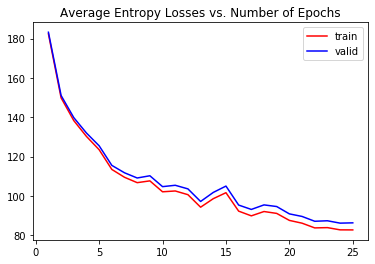

In [9]:
#plot the loss vs the number of epochs
plot_logs(my_autoencoder.logs)

## Testing the Network

Lets now add some noise to a few test images and try reconstructing them using the network

Example of Noisy Images: 


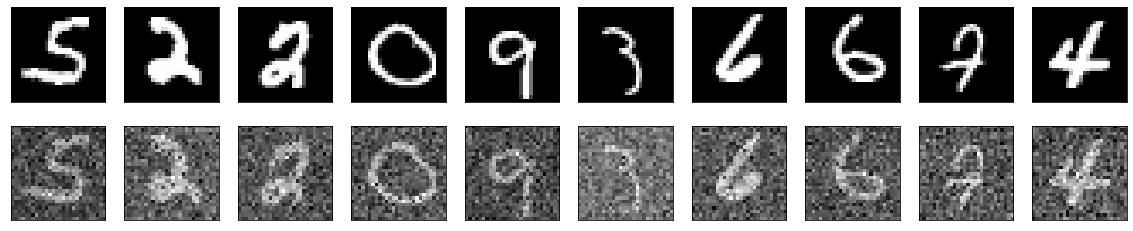

Examples of Reconstructed Images: 


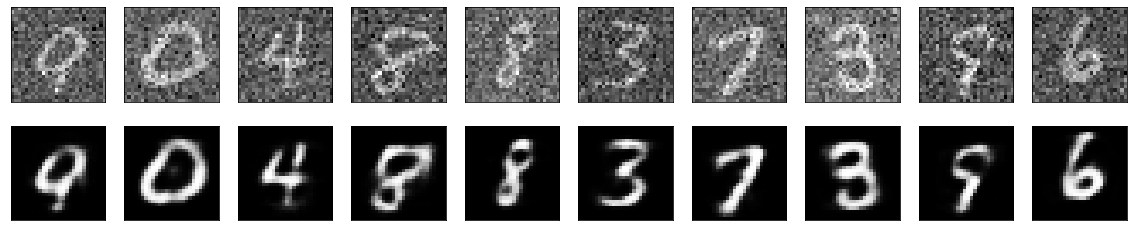

In [10]:
print("Example of Noisy Images: ")
X_noisy = my_autoencoder.add_noise(X_train,display=True)

print("Examples of Reconstructed Images: ")
my_autoencoder.visualize_decoded(X_noisy)

We can see that our network performs really well and is able to remove all noise and reconstruct the images given to it.